In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

CSV_PATH = "education_policies.csv"
TRAIN_PATH = "train_policies.csv"
TEST_PATH = "test_policies.csv"

def generate_synthetic_policies(n=500):
    states = ["Karnataka","Maharashtra","Tamil Nadu","Uttar Pradesh","Delhi","Kerala","West Bengal","Gujarat","Rajasthan","Punjab"]
    sectors = ["Primary","Secondary","Higher Education","Vocational","Early Childhood"]
    target_groups = ["Students","Teachers","Rural Students","Urban Students","Women","Disadvantaged Groups","All"]
    statuses = ["Proposed","Implemented","Under Review","Pilot"]
    years = list(range(2015, 2026))
    stakeholders_list = [
        "Ministry of Education, Local NGOs",
        "State Education Department, Private Partners",
        "Teachers' Unions, Community Leaders",
        "Central Government, Donors",
        "EdTech Companies, Universities"
    ]
    funding_ranges = [(0.5,5),(5,20),(20,100),(0.1,0.5)]
    aspects = ["learning outcomes","infrastructure","teacher quality","digital access","early childhood development","vocational skills"]
    interventions = ["grants to schools","teacher training programs","digital device distribution","curriculum reform","scholarship schemes","public-private partnerships"]
    focuses = ["marginalized communities","gender equity","rural accessibility","urban inclusion","STEM education","literacy and numeracy"]
    secondary_aspects = ["community participation","governance","assessment quality","safety standards"]

    records = []
    for i in range(1, n+1):
        policy_id = f"P{1000+i}"
        title = f"{random.choice(['National','State','District'])} {random.choice(sectors)} Education Reform {random.randint(1,99)}"
        sector = random.choice(sectors)
        region = random.choice(states)
        year = random.choice(years)
        target_group = random.choice(target_groups)
        status = random.choice(statuses)
        funding = round(random.uniform(*random.choice(funding_ranges)), 2)
        stakeholders = random.choice(stakeholders_list)
        impact_score = round(random.uniform(0.1, 0.99), 3)
        summary = f"This policy aims to improve {random.choice(aspects)} in {sector} through {random.choice(interventions)} in {region}."
        goals = f"Increase reach by {random.randint(5,40)}% in {random.randint(1,5)} years."
        full_text = f"{summary} Goals: {goals}"

        records.append({
            "policy_id": policy_id,
            "title": title,
            "sector": sector,
            "region": region,
            "year": year,
            "target_group": target_group,
            "status": status,
            "funding_million_usd": funding,
            "stakeholders": stakeholders,
            "impact_score": impact_score,
            "summary": summary,
            "goals": goals,
            "full_text": full_text
        })

    return pd.DataFrame(records)

def preprocess(df):
    df = df.copy()
    df["text_for_nlp"] = (df["title"].astype(str) + ". " + df["full_text"].astype(str) + ". Stakeholders: " + df["stakeholders"].astype(str)).str.lower()
    return df

# Generate data
if not os.path.exists(CSV_PATH):
    df = generate_synthetic_policies(500)
    df.to_csv(CSV_PATH, index=False)
else:
    df = pd.read_csv(CSV_PATH)

# Preprocess and split
df = preprocess(df)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

train_df.to_csv(TRAIN_PATH, index=False)
test_df.to_csv(TEST_PATH, index=False)

print(f"Data prepared: {len(train_df)} train, {len(test_df)} test.")


Data prepared: 400 train, 100 test.


In [2]:
# model

In [3]:
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

MODEL_PATH = "policy_vectorizer.pkl"
MATRIX_PATH = "policy_tfidf_matrix.pkl"

# Load train and full dataset
train_df = pd.read_csv("train_policies.csv") #  read the dataset 
full_df = pd.read_csv("education_policies.csv")

# --- FIX: Preprocess full_df so it has "text_for_nlp" ---
def preprocess(df):
    df = df.copy()
    df["text_for_nlp"] = (df["title"].astype(str) + ". " +
                          df["full_text"].astype(str) + ". Stakeholders: " +
                          df["stakeholders"].astype(str)).str.lower()
    return df

train_df = preprocess(train_df)
full_df = preprocess(full_df)

# Train TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) # model 

vectorizer.fit(train_df["text_for_nlp"]) # training 

# Transform full data
tfidf_matrix = vectorizer.transform(full_df["text_for_nlp"]) 

# Save model + matrix
joblib.dump(vectorizer, MODEL_PATH)
joblib.dump({"matrix": tfidf_matrix, "df": full_df}, MATRIX_PATH)

print(f"✅ Model trained and saved to {MODEL_PATH} and {MATRIX_PATH}")


✅ Model trained and saved to policy_vectorizer.pkl and policy_tfidf_matrix.pkl


TF-IDF matrix shape: (500, 1318), Sparsity: 7.12%
Top 20 words/phrases by TF-IDF importance:
and: 44.78
to: 40.11
education: 31.80
state: 22.28
reform: 21.28
includes: 21.27
learning: 21.09
improve: 21.03
on: 20.98
set: 20.71
strengthen: 20.62
monitoring: 19.62
community: 19.61
by: 18.69
goals: 18.55
education reform: 18.55
stakeholders: 18.55
vocational: 18.55
outcomes: 18.53
teachers: 18.34


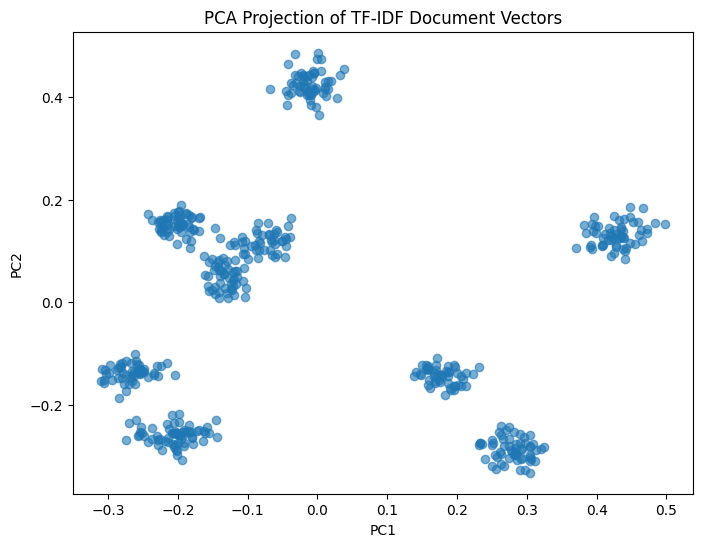

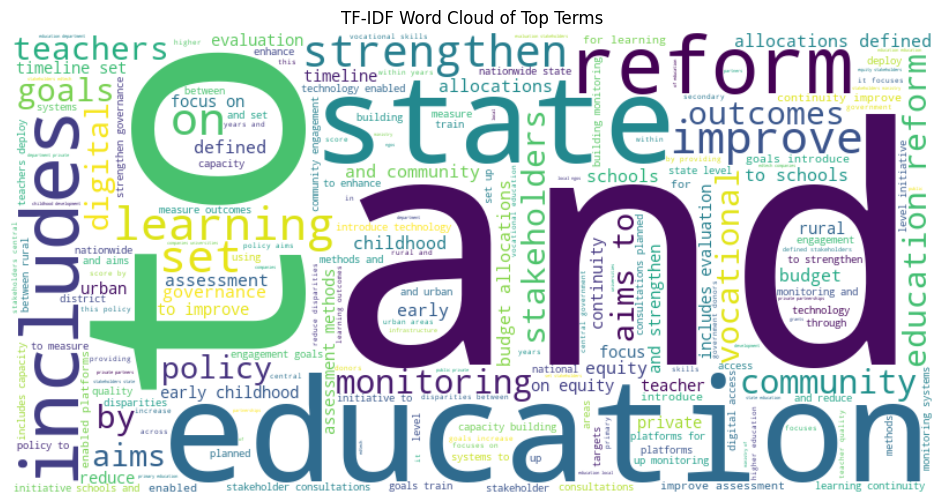

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from wordcloud import WordCloud

# --------------------------
# 1. Sparsity
# --------------------------
sparsity = 100.0 * (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}, Sparsity: {sparsity:.2f}%")

# --------------------------
# 2. Top 20 words in vocabulary
# --------------------------
feature_names = np.array(vectorizer.get_feature_names_out())
# Sum over all documents to get overall importance
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[::-1][:20]
print("Top 20 words/phrases by TF-IDF importance:")
for word, score in zip(feature_names[top_indices], tfidf_sum[top_indices]):
    print(f"{word}: {score:.2f}")

# --------------------------
# 3. PCA projection (2D) of documents
# --------------------------
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.6)
plt.title("PCA Projection of TF-IDF Document Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# --------------------------
# 4. Optional: Word cloud of top words
# --------------------------
top_words_dict = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of Top Terms")
plt.show()


In [6]:
# Load model

In [7]:
import textwrap
import joblib
from sklearn.metrics.pairwise import cosine_similarity

MODEL_PATH = "policy_vectorizer.pkl"
MATRIX_PATH = "policy_tfidf_matrix.pkl"

vectorizer = joblib.load(MODEL_PATH)

data = joblib.load(MATRIX_PATH) 


tfidf_matrix = data["matrix"]
df = data["df"]

def answer_query(query, top_k=3):
    query_vec = vectorizer.transform([query.lower()])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_idx = sims.argsort()[::-1][:top_k]

    print(f"\n🔎 Query: {query}")
    for idx in top_idx:
        row = df.iloc[idx]
        snippet = textwrap.shorten(row["full_text"], width=250, placeholder="...")
        print(f"\n📌 {row['title']} ({row['policy_id']}) | Score={sims[idx]:.3f}")
        print(f"Region: {row['region']} | Year: {row['year']} | Status: {row['status']}")
        print(f"Summary: {snippet}")

# Example query
answer_query("teacher training and capacity building initiatives", top_k=3)



🔎 Query: teacher training and capacity building initiatives

📌 National Primary Education Reform 6 (P1003) | Score=0.295
Region: Delhi | Year: 2016 | Status: Implemented
Summary: Policy to enhance teacher quality and assessment quality using teacher training programs. Includes capacity-building, monitoring and community engagement. Goals: Introduce technology-enabled platforms for learning continuity, improve assessment...

📌 State Higher Education Education Reform 76 (P1316) | Score=0.282
Region: Gujarat | Year: 2023 | Status: Proposed
Summary: Policy to enhance teacher quality and safety standards using teacher training programs. Includes capacity-building, monitoring and community engagement. Goals: Introduce technology-enabled platforms for learning continuity, improve assessment...

📌 State Early Childhood Education Reform 66 (P1372) | Score=0.279
Region: Maharashtra | Year: 2019 | Status: Proposed
Summary: Policy to enhance teacher quality and assessment quality using teacher tr

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Load saved models
vectorizer = joblib.load("policy_vectorizer.pkl")
data = joblib.load("policy_tfidf_matrix.pkl")
tfidf_matrix = data["matrix"]
full_df = data["df"]

# --------------------------
# Query function
# --------------------------
def query_policy(question, top_k=3):
    """
    Returns top_k matching policies for the input question/query.
    """
    # Preprocess the query similarly
    query_text = question.lower()
    
    # Vectorize
    query_vec = vectorizer.transform([query_text])
    
    # Compute cosine similarity
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    # Get top k indices
    top_indices = sims.argsort()[::-1][:top_k]
    
    # Return policy info
    results = []
    for idx in top_indices:
        row = full_df.iloc[idx]
        results.append({
            "title": row["title"],
            "stakeholders": row["stakeholders"],
            "similarity": float(sims[idx])
        })
    return results

# --------------------------
# Demo usage
# --------------------------
question = "How are teacher trainings implemented in rural schools?"
top_matches = query_policy(question, top_k=3)

for i, res in enumerate(top_matches, 1):
    print(f"{i}. {res['title']} (Stakeholders: {res['stakeholders']}, Similarity: {res['similarity']:.2f})")


1. District Early Childhood Education Reform 85 (Stakeholders: EdTech Companies, Universities, Similarity: 0.23)
2. National Secondary Education Reform 61 (Stakeholders: State Education Department, Private Partners, Similarity: 0.19)
3. State Vocational Education Reform 99 (Stakeholders: EdTech Companies, Universities, Similarity: 0.18)
